# DeepEnsemble modules

A notebook to walk through how to train and validate a Deep Ensemble model.

There are two options:
1) Run the source code using a command line argument.
2) Access the source code via individual modules.

After that we demonstrate:

3) Loading checkpoints
4) Making predictions for a test dataset
5) Predicting aleatoric uncertainty
6) Making loss plots

In [1]:
from deepuq.analyze.analyze import AggregateCheckpoints
from deepuq.models.models import model_setup_DE
from deepuq.data.data import DataPreparation
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from deepuq.train import train

In [2]:
# necessary in order to display matplotlib plots in a notebook environment
# when also running python scripts inline
%matplotlib inline

## 1. Command line argument
Here the dataset is generated on the fly using the `--generatedata` wildcard. The `save_data.ipynb` notebook generates how to train a model after first saving a dataframe.

In [83]:
noise = "high"
dim = "2D"
injection = "input"
n_models = 2
n_epochs = 100
size_df = 5000
out_dir = "../DeepUQResources/"

In order to save all of the model checkpoints, the two flags `--save_all_checkpoints` and `--save_final_checkpoint` must be specified.

Reading settings from cli and default,               dumping to temp config:  ./DeepUQResources/temp/temp_config_DE_20241105063109.yml
generating the data
generating dataframe
inflating starting size because sub-selecting                       uniform
bins for uniformity in y [0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2. ]
starting n_bin_values [6311, 3424, 2377, 1828, 1563, 1296, 1125, 956, 881, 722]


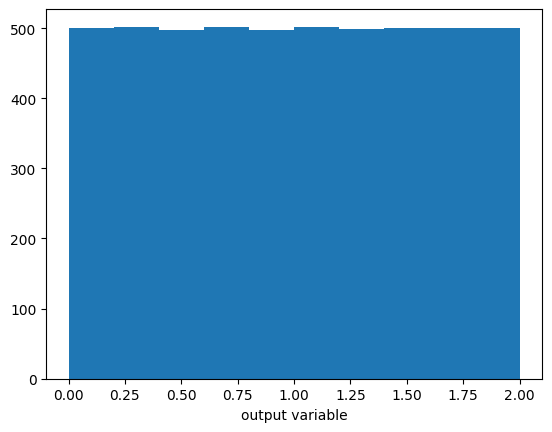

shape before cut (25000,)
shape once uniform (5000,)
size after uniform (5000, 32, 32)
shape of input (5000, 32, 32) shape of output (5000,) type of input <class 'numpy.ndarray'>


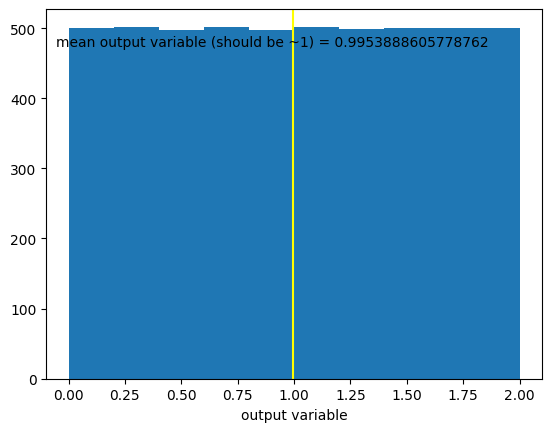

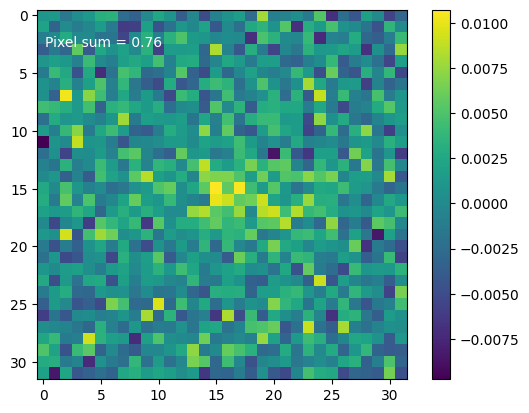

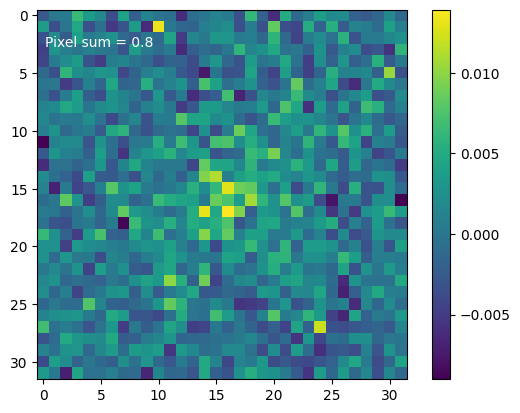

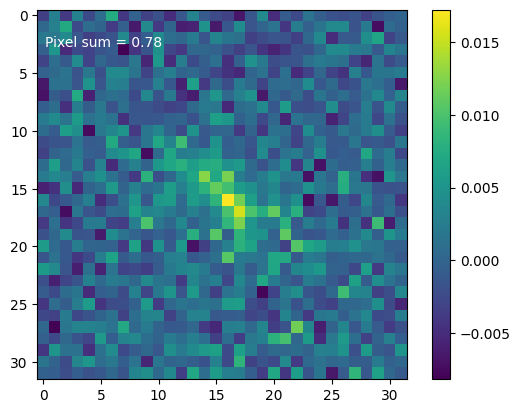

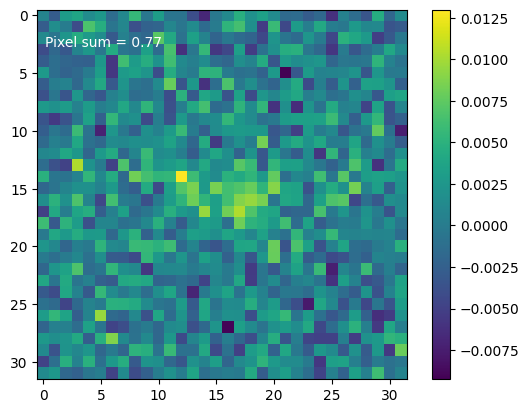

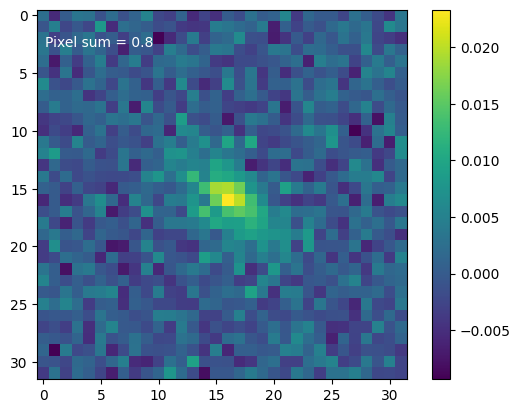

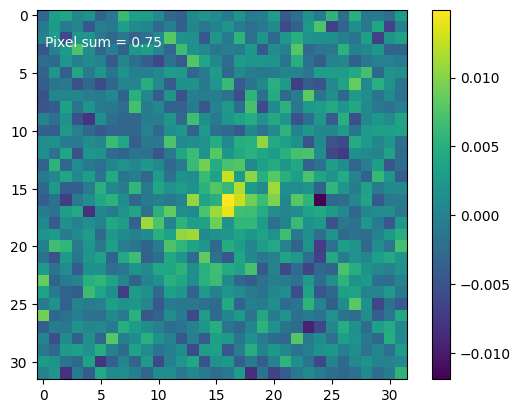

save final checkpoint has this value True
model name is  DE
dim is  2D
norm params None
starting here 0
model 0
final chk ../DeepUQResources/checkpoints/DE_input_2D_noise_high_beta_0.5_nmodel_0_epoch_99.pt
[]
model does not exist yet, going to save
model is Sequential(
  (0): ConvLayers(
    (conv1): Conv2d(1, 5, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(5, 5, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (pool1): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv3): Conv2d(5, 5, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (pool2): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv4): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (1): Model(
    (model): Sequential(
      (0): Linear(in_features=360, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64,

<Figure size 640x480 with 0 Axes>

In [84]:
# %run is the same as !python
%run ../deepuq/scripts/DeepEnsemble.py \
    --noise_level $noise \
    --n_models $n_models \
    --data_dimension $dim \
    --data_injection $injection \
    --size_df $size_df \
    --out_dir $out_dir \
    --n_epochs $n_epochs \
    --generatedata \
    --uniform \
    --overwrite_model \
    --save_all_checkpoints \
    --save_final_checkpoint \
    --verbose


If you run via the command line, you can access the saved checkpoints. Let's do that for one of the models

## 2. Train via the modules
The other option is to use the data, model, and train modules and functions to separately prepare the data, set up the model, and train. This produces the same saved checkpoints as the script above.

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_type = 'bnll_loss'
model, lossFn = model_setup_DE(loss_type, DEVICE)

Below are keywords that get auto-defined in the cli implementation that must be specified in this approach to training the model.

In [5]:
norm = False
uniform = True
verbose = False
val_prop = 0.1
rs = 42
BATCH_SIZE = 100

In [6]:
data = DataPreparation()
model_inputs, model_outputs = data.generate_df(
            size_df, noise, dim, injection, uniform, verbose)
x_train, x_val, y_train, y_val = data.train_val_split(
    model_inputs,
    model_outputs,
    val_proportion=val_prop,
    random_state=rs,
)
trainData = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
trainDataLoader = DataLoader(
    trainData, batch_size=BATCH_SIZE, shuffle=True
)

In [8]:
model_ensemble = train.train_DE(
        trainDataLoader,
        x_val,
        y_val,
        0.001,
        DEVICE,
        'bnll_loss',
        n_models,
        model_name='DE',
        BETA=0.5,
        EPOCHS=n_epochs,
        size_df=size_df,
        out_dir=out_dir,
        inject_type=injection,
        data_dim=dim,
        noise_level=noise,
        save_all_checkpoints=True,
        save_final_checkpoint=True,
        overwrite_model=True,
        plot_inline=False,
        plot_savefig=False,
        set_and_save_rs=False,
    )

model 0
final model already exists
going to overwrite the model
saved final checkpoint ../DeepUQResources/checkpoints/DE_input_2D_noise_low_beta_0.5_nmodel_0_epoch_99.pt
model 1
final model already exists
going to overwrite the model
saved final checkpoint ../DeepUQResources/checkpoints/DE_input_2D_noise_low_beta_0.5_nmodel_1_epoch_99.pt
model 2
final model already exists
going to overwrite the model
saved final checkpoint ../DeepUQResources/checkpoints/DE_input_2D_noise_low_beta_0.5_nmodel_2_epoch_99.pt
model 3
final model already exists
going to overwrite the model
saved final checkpoint ../DeepUQResources/checkpoints/DE_input_2D_noise_low_beta_0.5_nmodel_3_epoch_99.pt
model 4
final model already exists
going to overwrite the model
saved final checkpoint ../DeepUQResources/checkpoints/DE_input_2D_noise_low_beta_0.5_nmodel_4_epoch_99.pt


## 3. Loading checkpoints

Uncomment and run the below cell if you did not run the option 2 above (train via the modules).

In [ ]:
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [101]:
checkpoints = AggregateCheckpoints()

In [102]:
chk = checkpoints.load_checkpoint(
    "DE",
    injection,
    dim,
    noise,
    n_epochs - 1,
    DEVICE,
    path="../DeepUQResources/checkpoints/",
    BETA=0.5,
    nmodel=0
)

DE


The checkpoint contains a ton of useful information, including the training and validation MSE and $\beta-$NLL loss, and the weights and biases for the model that are required to re-run and the trained model on new data.

In [103]:
# set up the model and then load the checkpoint
DEmodel, lossFn = model_setup_DE(
    "bnll_loss", DEVICE, n_hidden=64, data_type=dim)

In [104]:
# define the model at this epoch
DEmodel.load_state_dict(chk.get("model_state_dict"))
# checkpoint['model_state_dict'])
DEmodel.eval()

Sequential(
  (0): ConvLayers(
    (conv1): Conv2d(1, 5, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(5, 5, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (pool1): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv3): Conv2d(5, 5, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (pool2): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv4): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (1): Model(
    (model): Sequential(
      (0): Linear(in_features=360, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=2, bias=True)
    )
  )
  (2): MuVarLayer()
)

## 4. Make predictions for a test dataset

generating dataframe
inflating starting size because sub-selecting                       uniform
bins for uniformity in y [0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2. ]
starting n_bin_values [646, 335, 225, 177, 154, 137, 116, 105, 86, 81]


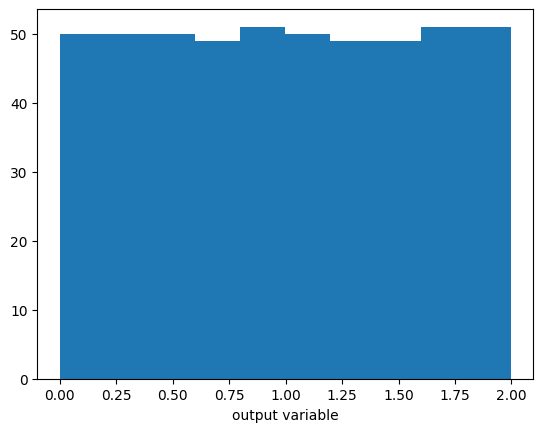

shape before cut (2500,)
shape once uniform (500,)
size after uniform (500, 32, 32)


In [105]:
size_df_test = 500
verbose = True
data = DataPreparation()
x_test, y_test = data.generate_df(
            size_df_test, noise, dim, injection, uniform, verbose)

In [106]:
y_pred = DEmodel(
    torch.Tensor(x_test
        )
    ).detach().numpy()

[]

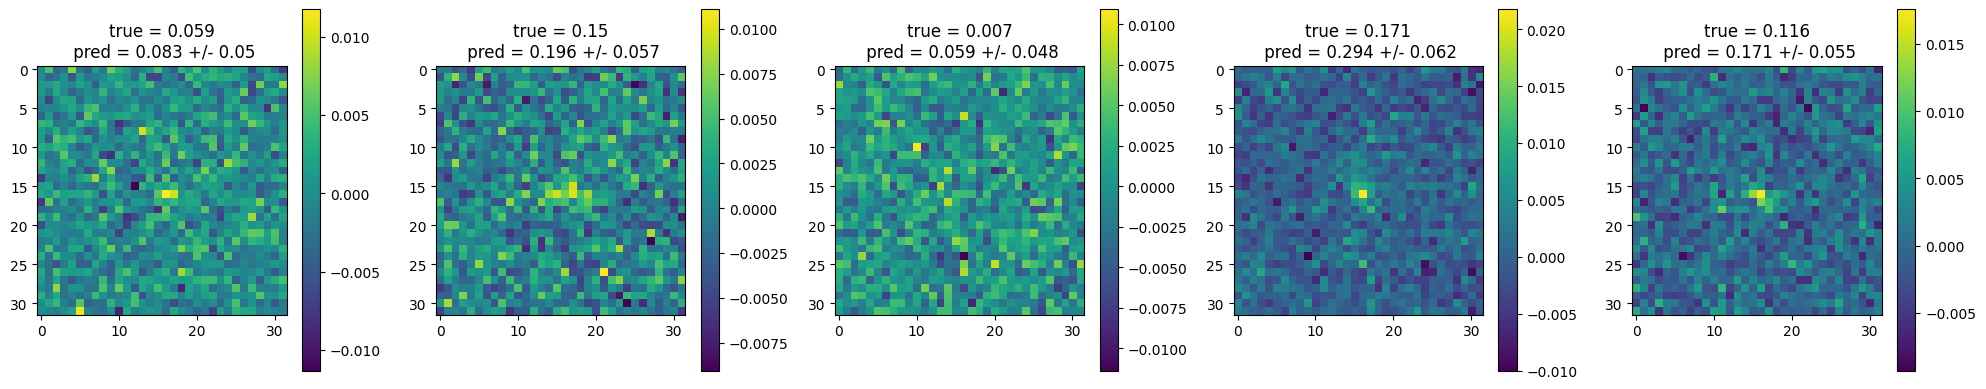

In [107]:
# Create a figure with 5 subplots in a horizontal row
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Loop through each subplot
for i in range(5):
    
    ax = axes[i]
    ax.imshow(x_test[i, :, :], aspect='auto')
    ax.set_title(
        'true = '+str(round(y_test[i],3))+'\n pred = '
        +str(round(y_pred[i,0],3))+' +/- '+str(round(np.sqrt(y_pred[i,1]),3)))
    ax.figure.colorbar(ax.images[0], ax=ax)
    ax.set_aspect('equal')

# Show the complete figure
plt.tight_layout()
plt.plot()

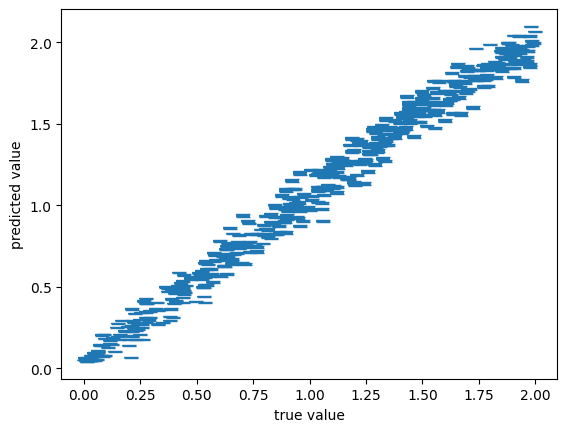

In [111]:
plt.errorbar(
            y_test,
            y_pred[:, 0],
            yerr=y_pred[:,1],
            lw=10,
            ls='None',
            capsize=5
        )
'''plt.scatter(
            y_test,
            y_pred[:, 0],
            s=30,
        )
'''
#plt.plot([0,2],[0,2], ls='--', color='black')
plt.xlabel('true value')
plt.ylabel('predicted value');

## 5. Predicting aleatoric uncertainty
Look at the output aleatoric uncertainty values, which are averaged over the entire test set and then averaged over all models in the ensemble.


In [112]:
u_al = []
for m in range(n_models):
    chk = checkpoints.load_checkpoint(
        "DE",
        injection,
        dim,
        noise,
        n_epochs - 1,
        DEVICE,
        path="../DeepUQResources/checkpoints/",
        nmodel=m
    )
    # define the model at this epoch
    DEmodel.load_state_dict(chk.get("model_state_dict"))
    # checkpoint['model_state_dict'])
    DEmodel.eval()
    y_pred = DEmodel(
        torch.Tensor(x_test
            )
        ).detach().numpy()
    
    u_al_one = np.sqrt(y_pred[:, 1])
    # sometimes a DE model can fail and the way to identify this
    # is when all elements of the predicted aleatoric uncertainty
    # array are the same:
    if len(set(u_al_one)) == 1:
        continue
    u_al.append(u_al_one)

DE
DE


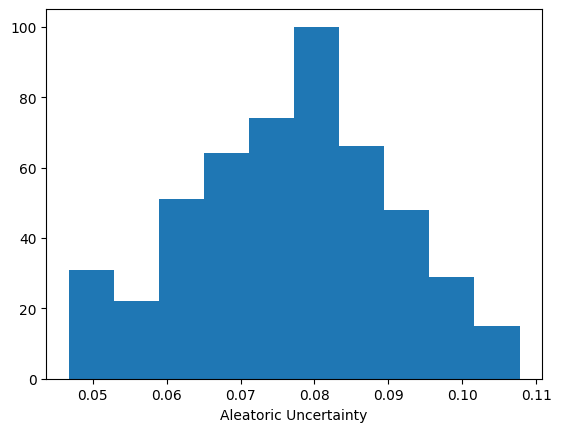

In [113]:
plt.hist(np.concatenate(u_al))
plt.xlabel('Aleatoric Uncertainty')
plt.show()

## 6. Loss plots
Let's also plot the loss history for these models alongside the MSE metric, which we also save in the checkpoints for each epoch.

In [114]:
train_loss = []
train_mse = []
valid_loss = []
valid_mse = []
for e in range(n_epochs):
    chk = checkpoints.load_checkpoint(
        "DE",
        injection,
        dim,
        noise,
        e,
        DEVICE,
        path="../DeepUQResources/checkpoints/",
        nmodel=m
    )
    train_loss.append(chk['train_loss'])
    train_mse.append(chk['train_mse'])
    valid_loss.append(chk['valid_loss'])
    valid_mse.append(chk['valid_mse'])

DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE
DE


<Figure size 640x480 with 0 Axes>

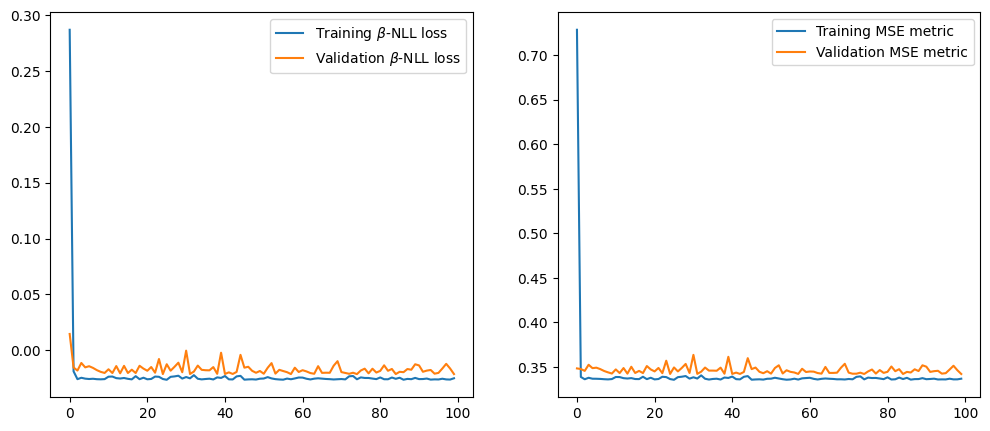

In [115]:
plt.clf()
fig = plt.figure(figsize=(12,5))
ax0 = fig.add_subplot(121)
ax0.plot(range(n_epochs), train_loss, label=r'Training $\beta$-NLL loss')
ax0.plot(range(n_epochs), valid_loss, label=r'Validation $\beta$-NLL loss')
ax0.legend()

ax1 = fig.add_subplot(122)
ax1.plot(range(n_epochs), train_mse, label='Training MSE metric')
ax1.plot(range(n_epochs), valid_mse, label='Validation MSE metric')
ax1.legend()
plt.show()